# 基于已有书名列表的豆瓣专题爬虫

- 需求：根据含有书名的Excel文件逐条查找补充书目信息，爬区豆瓣上的出版社、出版时间、ISBN、定价、评分、评分人数等；整合到pandas进行专题分析。
- 爬虫+数据分析：根据书名爬豆瓣获取书籍属性、整合到pandas，进行分析

本来打算直接用https://book.douban.com/subject_search?search_text={0}&cat=1001'.format('书名') 查询结构，没找到异步返回的数据json，绕了一圈后发现https://book.douban.com/j/subject_suggest?q={0}  可以用，就用了，通过比较名字和作者等确定url，然后直接爬该图书主页，然后写入字典。再变成dataframe。

In [1]:
#引入所需库
import json
import requests
import pandas as pd
from lxml import etree

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
bsdf=pd.read_excel('booklistfortest.xlsx') #读取书名Excel数据，为了简化，这里只用了"书名"列
#bsdf.head(3)

In [5]:
blst=list(bsdf['书名']) #书名列表
blst[0]

'龙族'

爬虫方面涉及到的：get，xpath去匹配，对于长度不定的一个html区域，不能写死xpath解析式，通过循环去取数，理清其HTML树结构；

一般解析是用BeautifulSoup或xpath，我更喜欢用xpath，因此下面的代码主要基于xpath解析文本。
以评分为例，鼠标点击评分部分，然后按Ctrl+Shift+I，或者右键点击检查元素，反正就是定位到评分对应的HTML上，定位到评分的代码部分后，右键，选择Copy->Copy XPath ,例如对于评分来说有：//*[@id="interest_sectl"]/div/div[2]/strong 通过con.xpath('//*[@id="interest_sectl"]/div/div[2]/strong/text()')就可以得到评分数据，返回的是列表，一般就是第0个值。同样，其他地方也是这样，而作者、出版社那几个属性是结构比较散的，需要特殊处理。

通过//*[@id="info"]/span[2] 可以确定 出版社 这个属性，但是属性的值，具体是哪个出版社不能确定，这些文字是在info这个节点上的。还是需要建立info的树结构

In [19]:
con.xpath('//*[@id="interest_sectl"]/div/div[2]/strong/text()')

[' 5.9 ']

In [8]:
def getBookInfo(binfo,cc):
    i=0
    rss={}
    k=''
    v=''
    f=0
    clw=[]
    for c in cc:
        if '\n' in c:
            if '\xa0' in c:
                clw.append(c)
        else:
            clw.append(c)
    
    for m in binfo[0]:
        if m.tag=='span':
            mlst=m.getchildren()
            if len(mlst)==0: 
                k=m.text.replace(':','')
                if '\xa0' in clw[i]:
                    f=1#需要m.tag=='a'下的值
                else:
                    v=clw[i].replace('\n','').replace(' ','')
                i+=1
            elif len(mlst)>0:#下面有子span 一种判断是m.attrib=={} 不够精确
                for n in mlst:
                    if n.tag=='span':
                        k=n.text.replace('\n','').replace(' ','') #不至于下面还有span，懒得用递归了
                    elif n.tag=='a':
                        v=n.text.replace('\n','').replace(' ','')
        
        elif m.tag=='a':
            if f==1: #是否可以不用这个if
                v=m.text.replace('\n','').replace(' ','')
                f=0
        elif m.tag=='br':
            if k=='':
                print(i,'err')
            else:
                rss[k]=v
        else:
            print(m.tag,i)
    return rss

调用上面函数返回的是一个字典，要整合到已有的字典里。涉及字典的组合，查了一下可以用d=dict(d,\*\*dw)，其中d是旧字典，dw是要加到d里的新字典，更简便的方式是用d.update(dw)函数，下面的代码就是用的update的。

主体代码如下，这个部分也可以打包为函数，因为jupyter里还是逐步分析方面就没打包

In [9]:
rlst=[]
for bn in blst:
    res={}
    r=requests.get('https://book.douban.com/j/subject_suggest?q={0}'.format(bn))
    rj=json.loads(r.text)
    #对rj进行一下验证和筛选
    html=requests.get(rj[0]['url']) #之后再考虑多个返回值的验证
    con = etree.HTML(html.text)
    bname=con.xpath('//*[@id="wrapper"]/h1/span/text()')[0] #和bn比较
    res['bname_sq']=bn
    res['bname']=bname
    res['dbid']=rj[0]['id'] #不需要存url，存id就够了
    #这部分取到info就够了，之后再用高级方法去匹配需要的元素，目前对应不对
    binfo=con.xpath('//*[@id="info"]')
    cc=con.xpath('//*[@id="info"]/text()')
    res.update(getBookInfo(binfo,cc))  #调用上面的函数处理binfo
    bmark=con.xpath('//*[@id="interest_sectl"]/div/div[2]/strong/text()')[0]
    if bmark=='  ':
        bits=con.xpath('//*[@id="interest_sectl"]/div/div[2]/div/div[2]/span/a/text()')[0]
        if bits=='评价人数不足':
            res['评分']=''
            res['评价人数']='评价人数不足'
        else:
            res['评分']=''
            res['评价人数']=''
    else:
        res['评分']=bmark.replace(' ','')
        bmnum=con.xpath('//*[@id="interest_sectl"]/div/div[2]/div/div[2]/span/a/span/text()')[0]
        res['评价人数']=bmnum
    rlst.append(res)

In [1]:
outdf=pd.DataFrame(rlst)

NameError: name 'pd' is not defined

In [20]:
#一般有多个返回值，简化只取第一个，所以就是用rj[0]['url']
#html=requests.get(rj[0]['url'])

In [21]:
rj[0]['url']

'https://book.douban.com/subject/26943161/'

In [22]:
con = etree.HTML(html.text)
binfo=con.xpath('//*[@id="info"]')
binfo[0]

<Element div at 0x19aad51ed08>

In [6]:
import re
def priceNorm(df):#用apply处理定价列
    pri=df['定价']
    pric=re.findall('^[0-9]+\.[0-9]+',pri)
    if pric==[]:
        print(pri)
        return float(pri)
    else:
        return float(pric[0])

## 简单统计数据分析

In [ ]:
outdf.to_excel('out_douban_binfo.xlsx',index=False) #输出数据

In [ ]:
# 数据合并
bdf=bsdf.merge(outdf,on='书名',how='left')

In [15]:
len(set(list(bdf['出版社'])))

97

In [ ]:
outdf.apply(priceNorm,axis=1)
#因为存在外国价格，就不直接转float了

In [16]:
# 基本统计值
#多少本书、多少个作者（作者国籍)、多少个出版社

print('一共有{0}本书，{1}个作者，{2}个出版社；'.format(len(bdf),len(set(list(bdf['作者']))),len(set(list(bdf['出版社'])))))

一共有421本书，309个作者，97个出版社；


In [21]:
#前几位的作者
bdf['作者'].value_counts().head(7)

[日]东野圭吾    15
刘慈欣        14
秦明          9
江南          9
萧鼎          8
雷米          5
吴军          4
Name: 作者, dtype: int64

In [24]:
#前6位都是小说类型的书，可以看一下吴军的是哪些书
bdf.loc[bdf['作者']=='吴军',['书名','阅读时间','阅读情况','出版社']]

,书名,阅读时间,阅读情况,出版社
104,数学之美,2016-10-20,P5,人民邮电出版社
234,智能时代,2017-06-22,P4,中信出版社
238,硅谷之谜,2017-07-01,P4,人民邮电出版社
385,见识--商业的本质和人生的智慧,2018-10-21,P4,中信出版社


In [101]:
#print(bdf.loc[bdf['作者']=='吴军',['书名','阅读时间','阅读情况','出版社']]) #print is easy to copy

In [25]:
#前几个出版社
bdf['出版社'].value_counts().head(7)

人民邮电出版社       36
EbookPress    30
中信出版社         24
机械工业出版社       22
北京大学出版社       19
电子工业出版社       19
清华大学出版社       13
Name: 出版社, dtype: int64

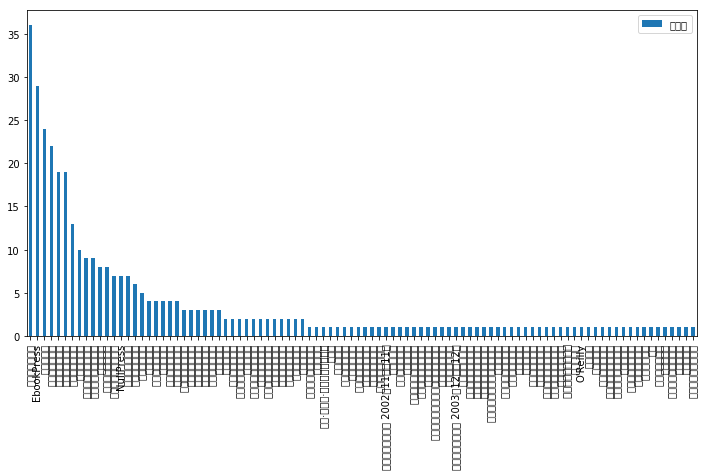

In [99]:
press=pd.DataFrame(bdf['出版社'].value_counts())
press.plot(kind='bar',figsize=(12,6))
#各家出版社的统计分布

In [32]:
bdf.loc[0,'阅读时间'].strftime('%Y-%m')

'2015-09'

In [6]:
r_date=bdf.loc[:,['阅读时间','书名']]

In [8]:
#r_date=r_date.cumsum()

In [26]:
#阅读时间按月统计（折线图）
bdf['阅读年月']=bdf['阅读时间'].apply(lambda x : x.strftime('%Y-%m'))

In [27]:
read_date=bdf['阅读年月'].value_counts() #每月阅读量，按月计数
read_date=pd.DataFrame(read_date,columns=['阅读年月']) #从Series变为DataFrame

In [29]:
read_date=read_date.sort_index()

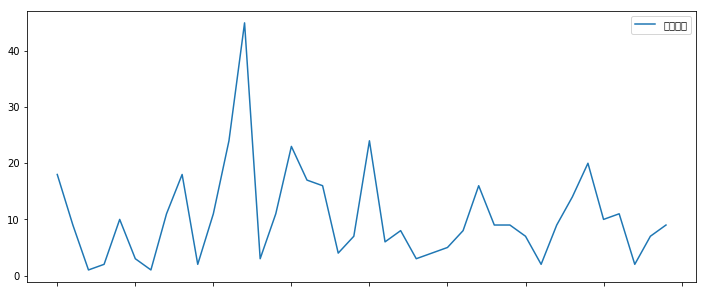

In [21]:
read_date.plot(figsize=(12,5)) #没调出来x坐标标签 xticks 不行

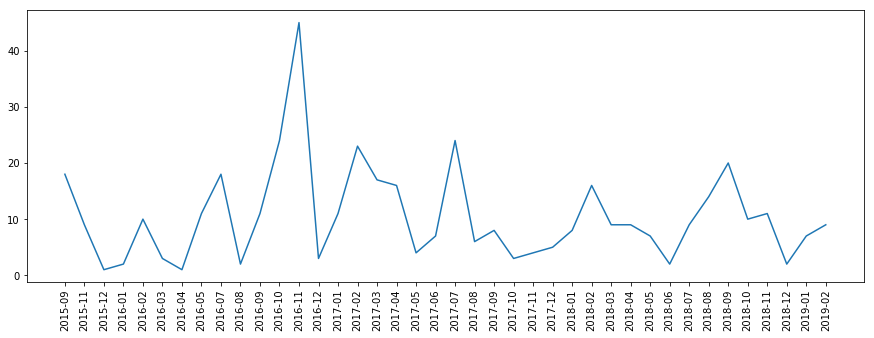

In [30]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)#设置时间标签显示格式
plt.plot(read_date)

In [31]:
bdf['阅读年']=bdf['阅读时间'].apply(lambda x : x.strftime('%Y'))
bdf['阅读月']=bdf['阅读时间'].apply(lambda x : x.strftime('%m')) #这里也可以用.month .year

In [33]:
r_dd=bdf.loc[:,['阅读年','阅读月']]


In [40]:
r_dd['val']=1

In [ ]:
r_ee=r_dd.groupby()

In [35]:
import numpy as np

In [41]:
pd.pivot_table(r_dd,values='val',index=['阅读月'],columns=['阅读年'],aggfunc=np.sum)

阅读年,2015,2016,2017,2018,2019
阅读月,,,,,
01,NaN,2.0,11.0,8.0,7.0
02,NaN,10.0,23.0,16.0,9.0
03,NaN,3.0,17.0,9.0,NaN
04,NaN,1.0,16.0,9.0,NaN
05,NaN,11.0,4.0,7.0,NaN
06,NaN,NaN,7.0,2.0,NaN
07,NaN,18.0,24.0,9.0,NaN
08,NaN,2.0,6.0,14.0,NaN
09,18.0,11.0,8.0,20.0,NaN


In [45]:
r_dd=pd.pivot_table(r_dd,values='val',index=['阅读月'],columns=['阅读年'],aggfunc=np.sum).fillna(value=0)
r_dd

阅读年,2015,2016,2017,2018,2019
阅读月,,,,,
01,0.0,2.0,11.0,8.0,7.0
02,0.0,10.0,23.0,16.0,9.0
03,0.0,3.0,17.0,9.0,0.0
04,0.0,1.0,16.0,9.0,0.0
05,0.0,11.0,4.0,7.0,0.0
06,0.0,0.0,7.0,2.0,0.0
07,0.0,18.0,24.0,9.0,0.0
08,0.0,2.0,6.0,14.0,0.0
09,18.0,11.0,8.0,20.0,0.0


In [47]:
r_dd.columns

Index(['2015', '2016', '2017', '2018', '2019'], dtype='object', name='阅读年')

In [48]:
r_dd=r_dd.loc[:,['2016','2017','2018']]

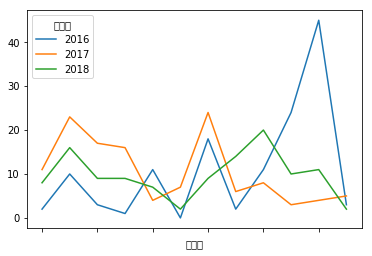

In [49]:
r_dd.plot()

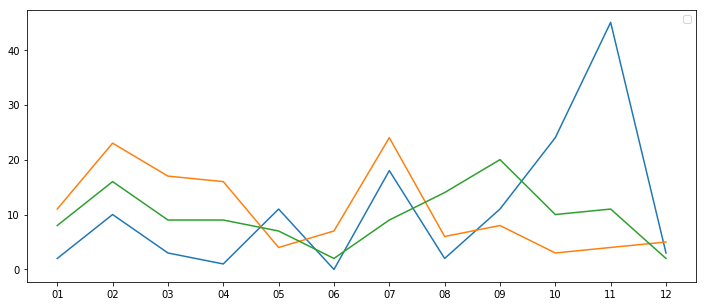

In [52]:
plt.figure(figsize=(12,5))
plt.legend(r_dd.columns)
plt.plot(r_dd)

<Figure size 432x288 with 0 Axes>

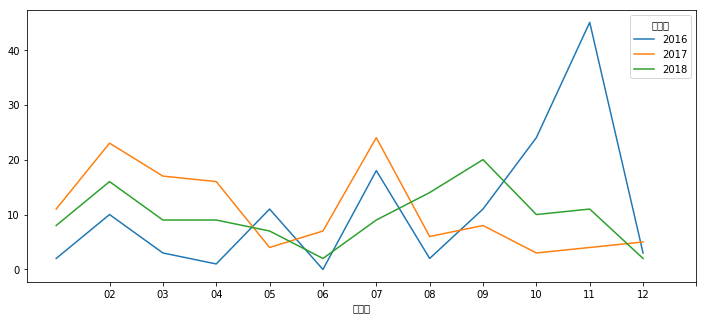

In [54]:
plt.figure()
r_dd.plot(xticks=range(1,13),figsize=(12,5))#;plt.legend(loc='best')

In [67]:
#数据相关的书籍
bdf['databook']=bdf['书名'].apply(lambda x: 'Y' if '数据' in x else 'N') #也可以用find()
dsbook=bdf.loc[(bdf['databook']=='Y'),['书名','作者','阅读时间','阅读情况','出版社','评分']]
print(len(dsbook))
dsbook.head(5)

37


,书名,作者,阅读时间,阅读情况,出版社,评分
108,大数据时代,维克托·迈尔·舍恩伯格,2016-10-25,P4,浙江人民出版社,7.5
109,删除：大数据取舍之道,维克托·迈尔·舍恩伯格,2016-10-27,P4,NaN,NaN
120,鲜活的数据：数据可视化指南,[美]Nathan Yau,2016-11-07,P3,人民邮电出版社,NaN
169,大话数据结构,程杰,2017-01-28,P3,清华大学出版社,7.9
219,利用Python进行数据分析,[美]Wes McKinney,2017-04-27,P3,机械工业出版社,8.5


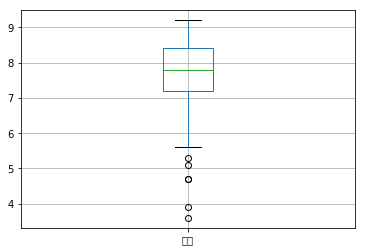

In [69]:
#评分分布（箱线图）
b_rank=pd.DataFrame(bdf['评分'])
b_rank.boxplot()

2015         AxesSubplot(0.1,0.679412;0.363636x0.220588)
2016    AxesSubplot(0.536364,0.679412;0.363636x0.220588)
2017         AxesSubplot(0.1,0.414706;0.363636x0.220588)
2018    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
2019             AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

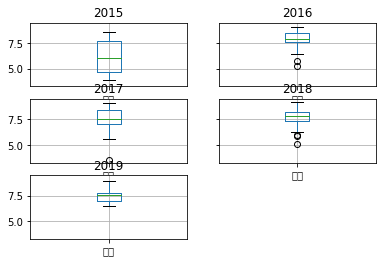

In [74]:
b_rk=bdf.loc[:,['阅读年','评分']] #根据年对评分进行统计，排列还需要加强，多设置些参数
b_rk.groupby('阅读年').boxplot()

In [30]:
#评分 top 10
bdf.sort_values(by='评分',ascending=False).head(10).loc[:,['书名','作者','阅读时间','阅读情况','出版社','评分']]

,书名,作者,阅读时间,阅读情况,出版社,评分
398,动物农场,[英]乔治·奥威尔,2018-11-13,P4,上海译文出版社,9.2
227,白夜行,[日]东野圭吾,2017-05-01,P5,南海出版公司,9.1
393,码农翻身,刘欣,2018-11-05,P4,电子工业出版社,9.1
288,图解密码技术,[日]结城浩,2018-01-15,P3,人民邮电出版社,9.1
205,逻辑与哲学,王路,2017-03-22,P3,人民出版社,9.1
51,从一到无穷大,[美] G·伽莫夫 / 校注 吴伯泽,2016-04-11,P4,科学出版社,9.1
64,超越时空,[日]加来道雄,2016-07-14,P4,上海科技教育出版社,9.0
356,永恒的终结,[美]艾萨克·阿西莫夫,2018-08-23,P5,江苏文艺出版社,9.0
346,轻松读懂财务报表,张昕,2018-07-16,P3,北京大学出版社,9.0
40,小王子,[法] 圣埃克苏佩里,2016-02-16,P4,人民文学出版社,9.0


In [85]:
#根据页数反算这些书一共有多少页
def bookpage(x):
    res=0
    try:
        res=int(x)
    except:
        res=0
    return res

In [86]:
bdf['页数']=bdf['页数'].apply(bookpage)

In [92]:
bdf['页数']=bdf['页数'].apply(lambda x : x if x<1000 else 200)

In [89]:
c_nna=274

In [81]:
print(len(bdf),bdf['页数'].count())
c_nna=bdf['页数'].count()

419 274


In [87]:
bdf['页数'].count()

419

In [88]:
bdf['页数'].sum()

278622

In [91]:
bdf['页数'].mean()

664.9689737470167

In [94]:
page_mean=bdf['页数'].sum()/c_nna
page_mean

284.3649635036496

In [95]:
page_mean*len(bdf)

119148.91970802919

## 试代码区域

返回的是json。
rj里面可以提取的属性：
- "title":"书名",
- "url":"对应书的网页",
- "pic":"书的封面图资源位置",
- "author_name":"作者",
- "year":"出版年份",
- "type":"类型，书籍一般标为b，应该是指book",
- "id":"书的豆瓣id，可以对应其网页"

eg:
- 'title': '未来简史',
- 'url': 'https://book.douban.com/subject/26943161/',
- 'pic': 'https://img3.doubanio.com/view/subject/s/public/s29287103.jpg',
- 'author_name': '[以色列] 尤瓦尔·赫拉利',
- 'year': '2017',
- 'type': 'b',
- 'id': '26943161'

In [18]:
r=requests.get('https://book.douban.com/j/subject_suggest?q={0}'.format('未来简史'))
rj=json.loads(r.text)
rj

[{'title': '未来简史',
  'url': 'https://book.douban.com/subject/26943161/',
  'pic': 'https://img3.doubanio.com/view/subject/s/public/s29287103.jpg',
  'author_name': '[以色列] 尤瓦尔·赫拉利',
  'year': '2017',
  'type': 'b',
  'id': '26943161'},
 {'title': '未来简史',
  'url': 'https://book.douban.com/subject/26945094/',
  'pic': 'https://img1.doubanio.com/view/subject/s/public/s29317658.jpg',
  'author_name': '[以色列] 尤瓦尔·赫拉利',
  'year': '2016',
  'type': 'b',
  'id': '26945094'},
 {'title': '未来简史',
  'url': 'https://book.douban.com/subject/4891197/',
  'pic': 'https://img3.doubanio.com/view/subject/s/public/s6263884.jpg',
  'author_name': '(法) 阿塔利',
  'year': '2010',
  'type': 'b',
  'id': '4891197'},
 {'title': '未來簡史',
  'url': 'https://book.douban.com/subject/30349873/',
  'pic': 'https://img3.doubanio.com/view/subject/s/public/s29893492.jpg',
  'author_name': '賈克‧阿塔利',
  'year': '2018',
  'type': 'b',
  'id': '30349873'},
 {'title': '未来人类简史',
  'url': 'https://book.douban.com/subject/26977428/',
 

In [79]:
bdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 21 columns):
书名          419 non-null object
阅读时间        419 non-null datetime64[ns]
作者          391 non-null object
阅读情况        404 non-null object
备注          186 non-null object
出版社         356 non-null object
出版社省份       282 non-null object
出版时间        345 non-null object
分类          373 non-null float64
来源          373 non-null float64
字数(千字)      65 non-null float64
页数          274 non-null object
ISBN        257 non-null object
外文书名        115 non-null object
评分          215 non-null float64
评价人数        227 non-null object
豆瓣id        235 non-null float64
阅读年月        419 non-null object
阅读年         419 non-null object
阅读月         419 non-null object
databook    419 non-null object
dtypes: datetime64[ns](1), float64(5), object(15)
memory usage: 68.8+ KB


## 参考文献

- https://lxml.de/api/lxml.etree._Element-class.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html